In [14]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import faiss
import numpy as np

In [15]:
class FaissKMeans:
  # https://github.com/facebookresearch/faiss/issues/2492
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.labels_=None
    def fit(self, data_dict):
        # X = np.array(data_dict['embeddings']).astype('float32')
        X = data_dict.astype('float32')
        faiss.normalize_L2(X)
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                 k=self.n_clusters,
                                 niter=self.max_iter,
                                 nredo=self.n_init,
                                 gpu = True,
                                 verbose = True)
                                 #index = quantizer)
        self.kmeans.train(X)
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        self.labels_ = self.predict(X)
  
    def predict(self, data_dict):
        X = data_dict.astype('float32')
        labels = [float(element) for element in self.kmeans.index.search(X, 1)[1]]
        return labels
  

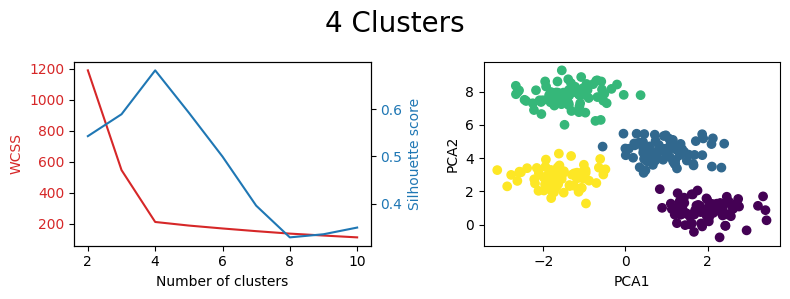

In [48]:
def auto_cluster(X, n=range(2,11)):
    n_range = n
    wcss = []
    silhouette_scores = []
    labels = []
    for i in n_range:
        kmeans = KMeans(n_clusters=i,  max_iter=300, n_init=10, random_state=0)
        # kmeans = FaissKMeans(n_clusters=i, max_iter=300, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        labels.append(kmeans.labels_)
    
    best_n_index = max(enumerate(silhouette_scores),key=lambda x: x[1])[0]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))

    color = 'tab:red'
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS', color=color)
    ax1.plot(n_range, wcss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1_twin = ax1.twinx()

    color = 'tab:blue'
    ax1_twin.set_ylabel('Silhouette score', color=color)
    ax1_twin.plot(n_range, silhouette_scores, color=color)
    ax1_twin.tick_params(axis='y', labelcolor=color)

    # Second plot
    ax2.scatter(X[:,0], X[:,1], c=labels[best_n_index])
    ax2.set_xlabel('PCA1')
    ax2.set_ylabel('PCA2')

    fig.suptitle('{} Clusters'.format(best_n_index+2), fontsize=20)
    fig.tight_layout()

    plt.show()
    
# X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
# X = FAISS.load_local('faiss_db')

# auto_cluster(X)